# Проект: Дашборд конверсий

### Импортируем нужные библиотеки:
###### 1. pandas и numpy для обработки данных;
###### 2. requests для обработки данных из HTTP-запроса
###### 4. matplotlib и seaborn для визуализаций
*
*
*
*
*
*
###### 5. dotenv и os для 

In [ ]:
import os
from dotenv import load_dotenv
import pandas as pd
import numpy as np
import requests as rq
import matplotlib.pyplot as plt
import seaborn as sns

## 1. Получаем данные посетителей и зарегистрировавшихся

##### 1.1 Выгрузка переменных окружения и создание папки для графиков

In [ ]:
load_dotenv() # загружаются переменные из файла .env

# Создаём .env файл
env_content = """API_URL=https://data-charts-api.hexlet.app
DATE_BEGIN=2023-03-01
DATE_END=2023-09-01"""

with open('.env', 'w', encoding='utf-8') as f:
    f.write(env_content)

# Получаем значения переменных окружения
API_URL = os.getenv('API_URL')
DATE_BEGIN = os.getenv('DATE_BEGIN')
DATE_END = os.getenv('DATE_END')

# Создаем директорию для графиков
if not os.path.exists('./charts'):
    os.makedirs('./charts')

##### 1.2 Добавляем датафрейм с посещениями

In [ ]:
#https://data-charts-api.hexlet.app/visits?begin=2023-03-01&end=2023-09-01
visits_url = rq.get(f'{API_URL}/visits?begin={DATE_BEGIN}&end={DATE_END}')
json_df_visits_url = visits_url.json()
visits_df_url = pd.DataFrame(json_df_visits_url)

visits_df_url

##### 1.3 Добавляем датафрейм с регистрациями

In [ ]:
#https://data-charts-api.hexlet.app/registrations?begin=2023-03-01&end=2023-09-01
regs_url = rq.get(f'{API_URL}/registrations?begin={DATE_BEGIN}&end={DATE_END}')
json_df_regs_url = regs_url.json()
regs_df_url = pd.DataFrame(json_df_regs_url)

regs_df_url

## 2. Краткая сводка по данным

##### 2.1 Данные с посетителями

In [ ]:
visits_df_url.info()

##### 2.2 Данные с зарегистрировавшимися

In [ ]:
regs_df_url.info()

## 3. Считаем конверсию из посетителей в зарегистрировавшихся 

##### 3.1 Обрабатывааем визиты

In [ ]:
# Преобразуем datetime
visits_df_url['datetime'] = pd.to_datetime(visits_df_url['datetime'])

# Обрабатываем визиты - фильтруем ботов и берем последний визит
visits_clean = visits_df_url[~visits_df_url['user_agent'].str.contains('bot', case=False, na=False)]
visits_last = visits_clean.sort_values('datetime').groupby('visit_id').last().reset_index()
visits_last['date_group'] = visits_last['datetime'].dt.date
# Группируем визиты по дате и платформе
visits_grouped = visits_last.groupby(['date_group', 'platform']).size().reset_index(name='visits')

visits_grouped

##### 3.2 Обрабатываем регистриции

In [ ]:
# Преобразуем datetime
regs_df_url['datetime'] = pd.to_datetime(regs_df_url['datetime'])

# Обрабатываем регистрации
regs_df_url['date_group'] = regs_df_url['datetime'].dt.date
regs_grouped = regs_df_url.groupby(['date_group', 'platform']).size().reset_index(name='registrations')

regs_grouped

##### 3.3 Объединяем и рассчитываем конверсию

In [6]:
merged_df = pd.merge(visits_grouped, regs_grouped, on=['date_group', 'platform'], how='left')
merged_df['registrations'] = merged_df['registrations'].fillna(0)
merged_df['conversion'] = (merged_df['registrations'] / merged_df['visits'] * 100).round(6)

# Сортируем и сохраняем
merged_df = merged_df.sort_values(['date_group', 'platform']).reset_index(drop=True)
merged_df

,date_group,platform,visits,registrations,conversion
0,2023-03-01,android,75,61,81.333333
1,2023-03-01,ios,22,18,81.818182
2,2023-03-01,web,279,8,2.867384
3,2023-03-02,android,67,59,88.059701
4,2023-03-02,ios,31,24,77.419355
...,...,...,...,...,...
547,2023-08-30,ios,66,40,60.606061
548,2023-08-30,web,1227,34,2.770986
549,2023-08-31,android,57,42,73.684211
550,2023-08-31,ios,50,36,72.000000


##### 3.4 Создаём json файл с конверсией из покупателей в регистрации

In [7]:
merged_df.to_json('./conversion.json')

## 4. Выводим данные по рекламным кампаниям

##### 4.1 Создаём датафрейм о рекламных компаниях

In [8]:
#добавляем датафрейм о рекламных кампаниях
ads_df = pd.read_csv('ads.csv')
ads_df

,date,utm_source,utm_medium,utm_campaign,cost
0,2023-03-01 10:54:41,google,cpc,advanced_algorithms_series,212
1,2023-03-02 10:32:35,google,cpc,advanced_algorithms_series,252
2,2023-03-03 19:21:40,google,cpc,advanced_algorithms_series,202
3,2023-03-04 17:52:04,google,cpc,advanced_algorithms_series,223
4,2023-03-05 5:35:13,google,cpc,advanced_algorithms_series,265
...,...,...,...,...,...
154,2023-09-13 5:34:02,vk,social,intro_to_python_course,277
155,2023-09-14 18:25:13,vk,social,intro_to_python_course,221
156,2023-09-15 15:35:47,vk,social,intro_to_python_course,175
157,2023-09-16 5:30:26,vk,social,intro_to_python_course,224


##### 4.2 Обрабатываем рекламные данные

In [9]:
# Преобразуем дату в ads.csv
ads_df['date_group'] = pd.to_datetime(ads_df['date']).dt.date

# Группируем рекламные данные по дате
ads_grouped = ads_df.groupby('date_group').agg({
    'cost': 'sum',
    'utm_campaign': 'first'
}).reset_index()

# Создаем датафрейм конверсий по дате (агрегируем по всем платформам)
conversion_by_date = merged_df.groupby('date_group').agg({
    'visits': 'sum',
    'registrations': 'sum'
}).reset_index()

# Объединяем с рекламными данными
ads_merged = pd.merge(conversion_by_date, ads_grouped, on='date_group', how='left')

# Заполняем пропущенные значения
ads_merged['cost'] = ads_merged['cost'].fillna(0)
ads_merged['utm_campaign'] = ads_merged['utm_campaign'].fillna('none')

# Сортируем по дате
ads_merged = ads_merged.sort_values('date_group').reset_index(drop=True)

ads_merged

,date_group,visits,registrations,cost,utm_campaign
0,2023-03-01,376,87,212.0,advanced_algorithms_series
1,2023-03-02,613,106,252.0,advanced_algorithms_series
2,2023-03-03,683,107,202.0,advanced_algorithms_series
3,2023-03-04,647,159,223.0,advanced_algorithms_series
4,2023-03-05,707,115,265.0,advanced_algorithms_series
...,...,...,...,...,...
179,2023-08-27,795,88,222.0,intro_to_python_course
180,2023-08-28,635,83,223.0,intro_to_python_course
181,2023-08-29,1268,143,190.0,intro_to_python_course
182,2023-08-30,1328,101,109.0,intro_to_python_course


##### 4.2 Создаём json файл с рекламой

In [10]:
# Сохраняем в JSON
ads_merged.to_json('./ads.json', orient='columns', date_format='epoch')

## 5. Визуализация

##### 5.1 Итоговые визиты

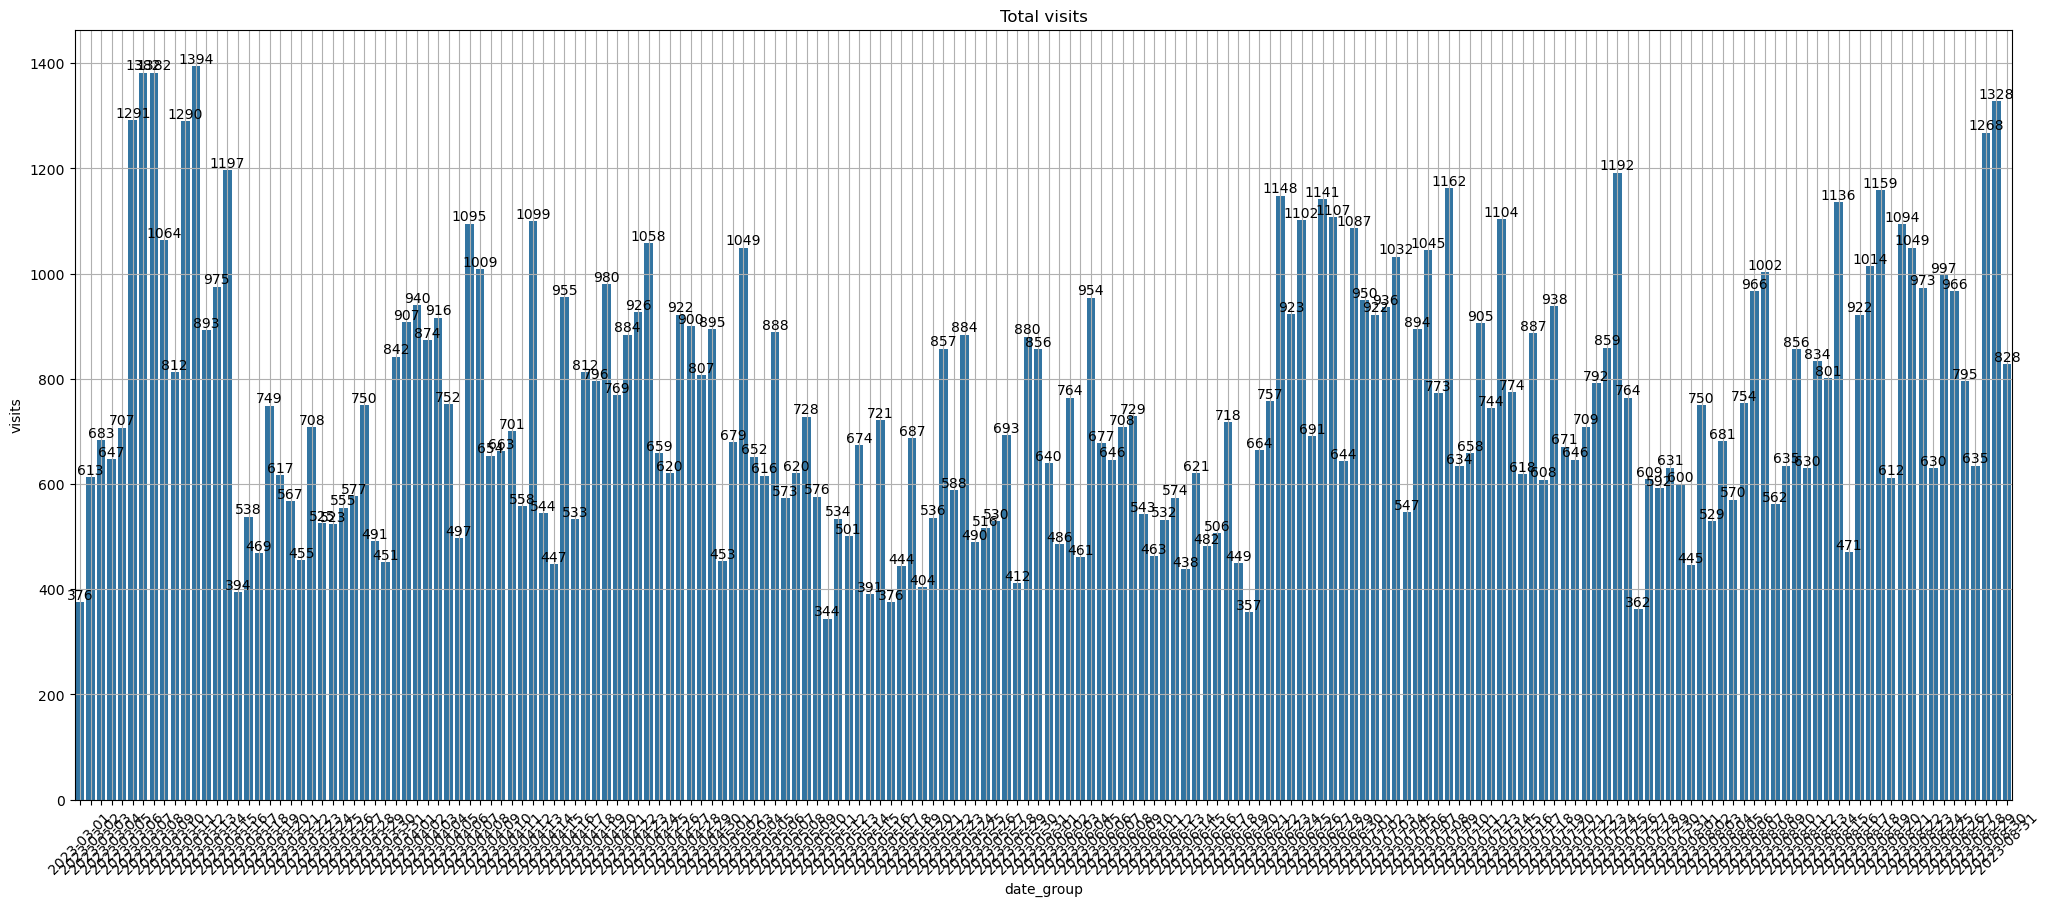

In [20]:
plt.figure(figsize = (25, 10))

ax = sns.barplot(
    x='date_group',
    y='visits',
    data=ads_merged
)
ax.bar_label(ax.containers[0])
plt.title('Total visits')
plt.xlabel('date_group')
plt.xticks(rotation=45)
plt.grid()

plt.show()

#Сохраняем график
#plt.savefig(f'./charts/1.visits_by_date.png')

##### 5.2 Итоговые визиты с разбивкой по платформам: web, android, ios

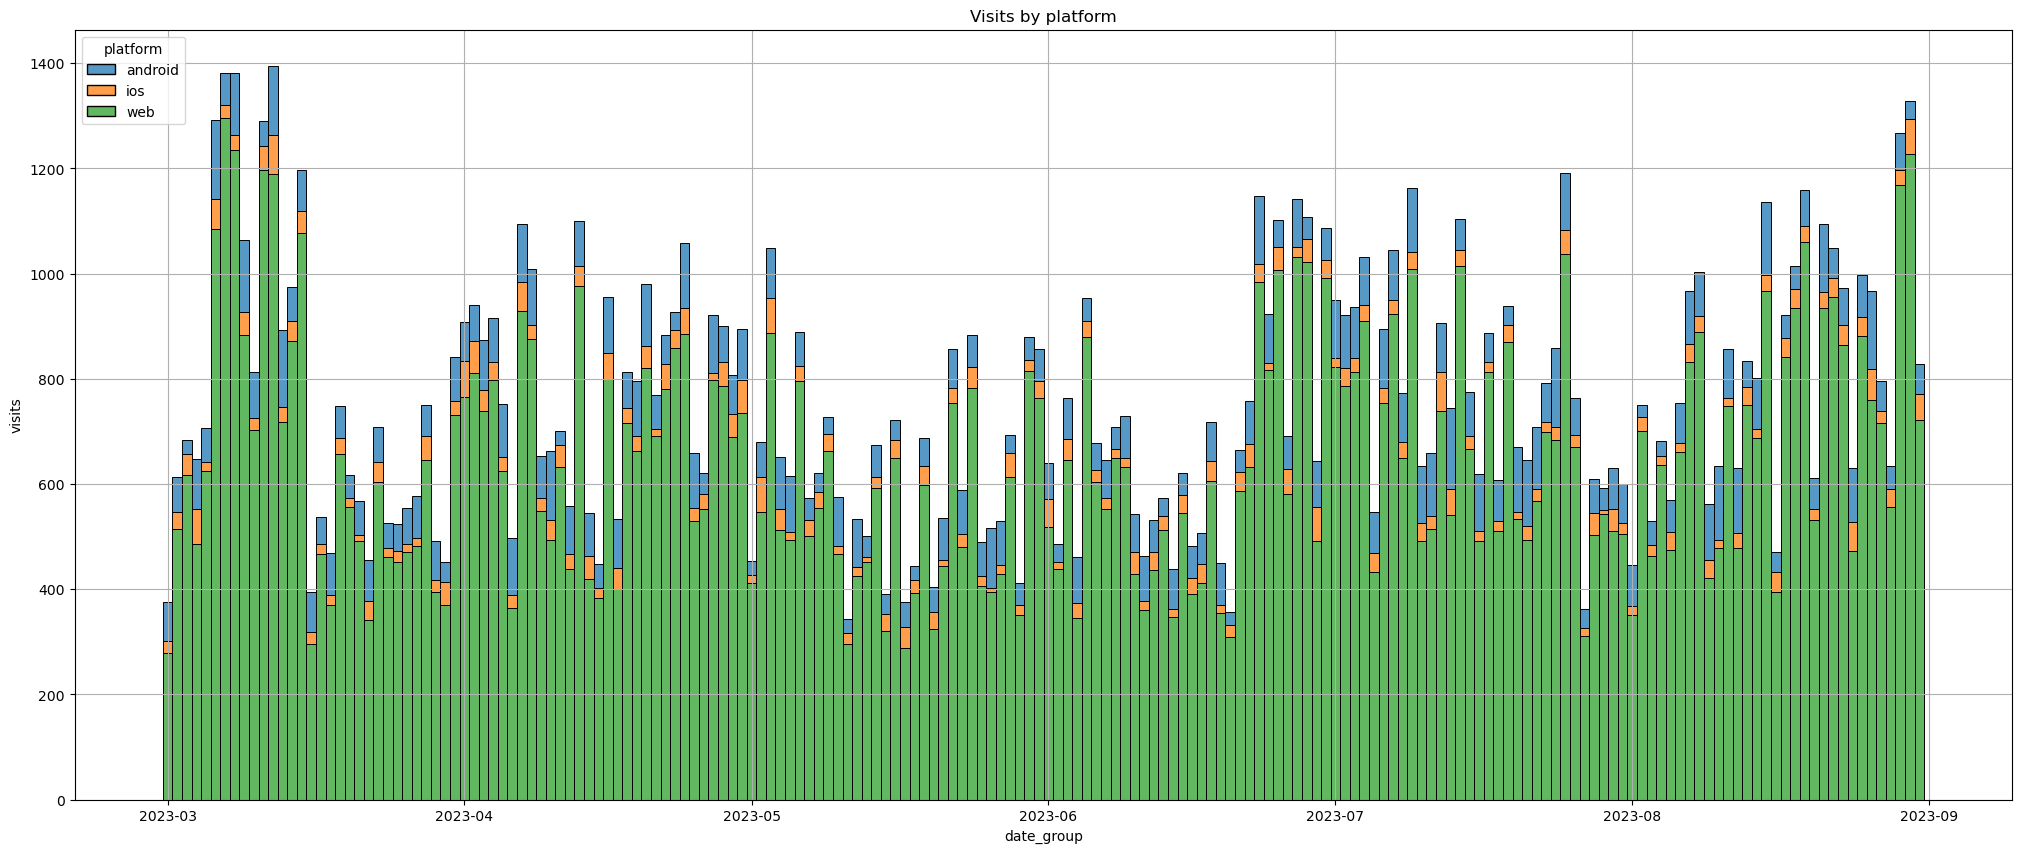

In [24]:
plt.figure(figsize=(25, 10))

ax = sns.histplot(
    x='date_group',
    weights='visits',
    hue='platform',
    data=merged_df,
    multiple='stack',
    bins=184
)

plt.title('Visits by platform')
plt.xlabel('date_group')
plt.ylabel('visits')
plt.grid(True)

plt.show()

#Сохраняем график
#plt.savefig('./charts/2.visits_by_web_andr_ios.png')

##### 5.3 Итоговые регистрации

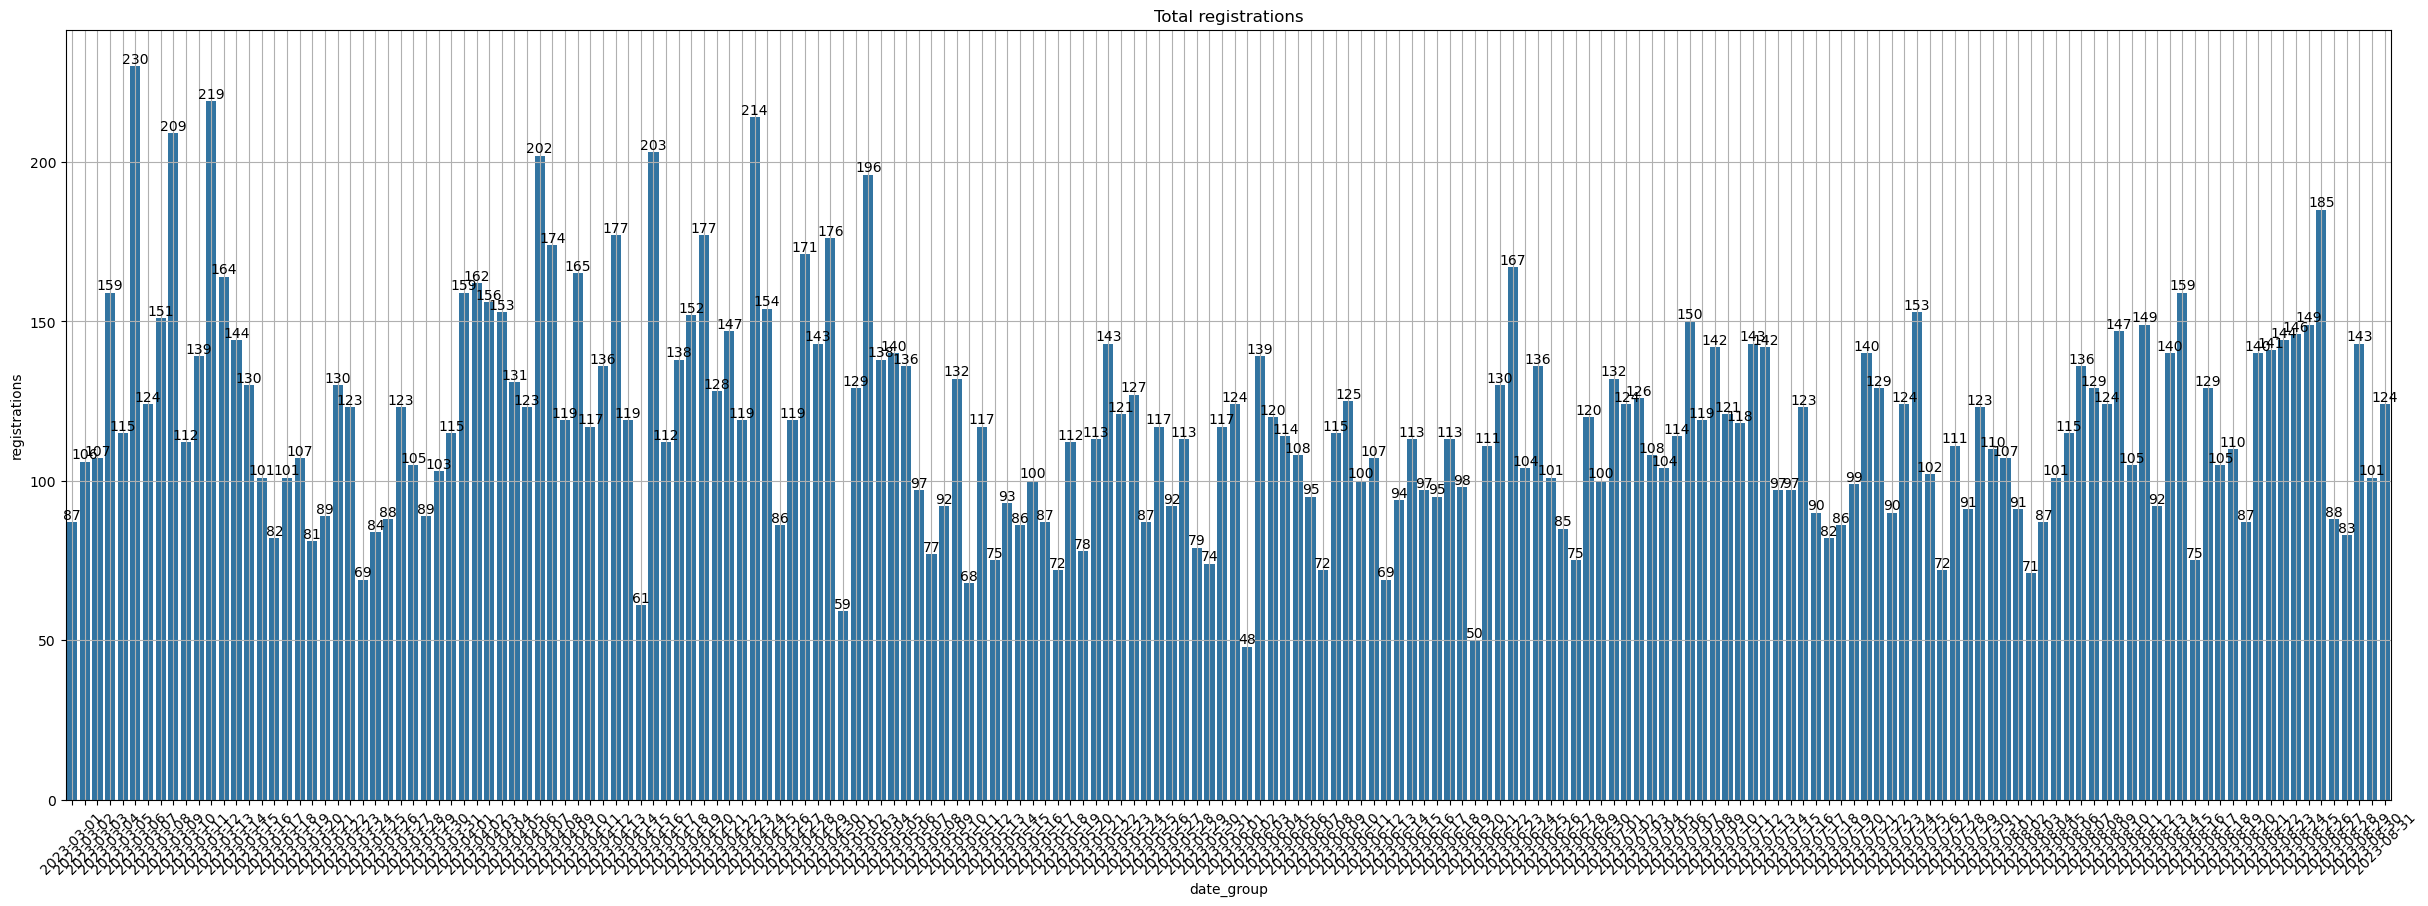

In [27]:
plt.figure(figsize = (30, 10))

ax = sns.barplot(
    x = 'date_group',
    y = 'registrations',
    data=ads_merged
)

ax.bar_label(ax.containers[0])
plt.title('Total registrations')
plt.xticks(rotation=45)
plt.grid()

plt.show()

#Сохраняем график
#plt.savefig('./charts/3.regs_by_date.png')

##### 5.4 Итоговые регистрации с разбивкой по платформе: web, android, ios

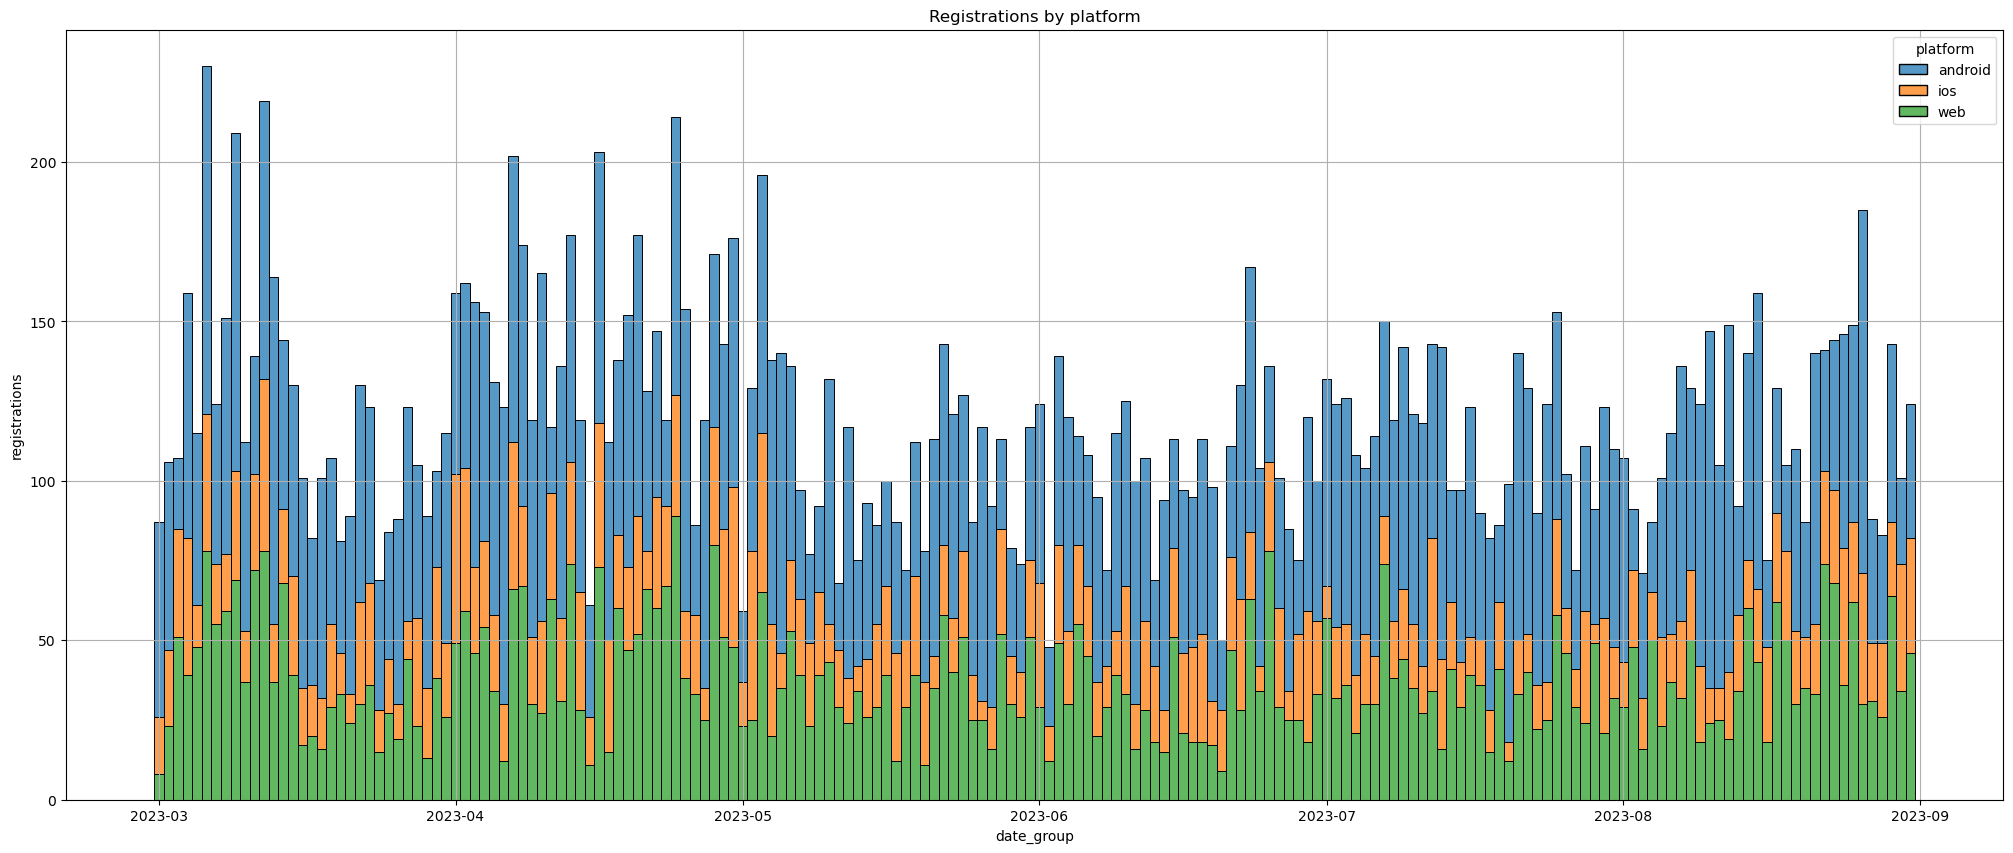

In [34]:
fig, ax = plt.subplots(figsize=(25, 10))

ax = sns.histplot(
    x='date_group',
    weights='registrations',
    hue='platform',
    data=merged_df,
    multiple='stack',
    bins=184
)

plt.title('Registrations by platform')
plt.xlabel('date_group')
plt.ylabel('registrations')
plt.grid(True)

plt.show()

#Сохраняем график
#plt.savefig('./charts/4.regs_web_andr_ios.png')

##### 5.5 Общая конверсия

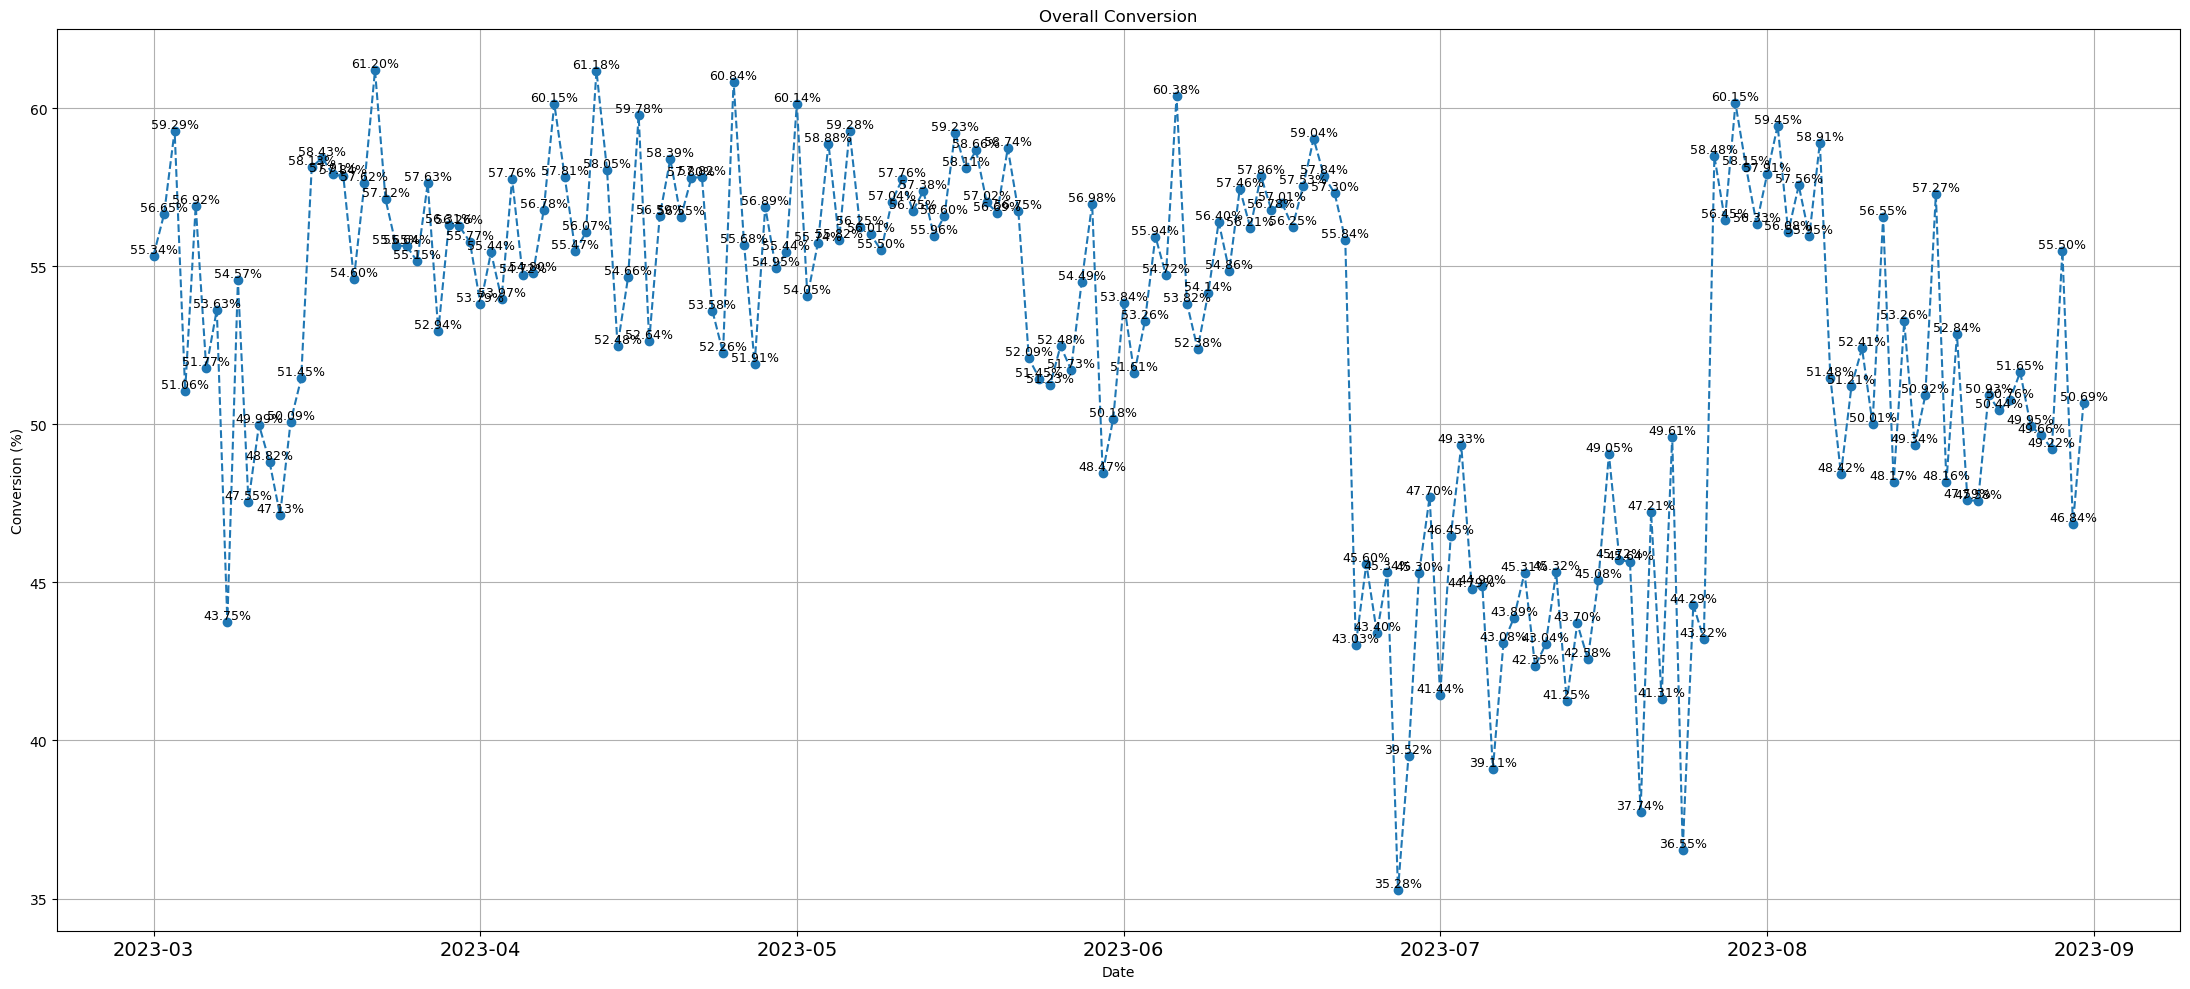

In [35]:
# Создаем final_df из merged_df
final_df = merged_df.copy()
final_df['date_group'] = pd.to_datetime(final_df['date_group'])

conversion_data = final_df.groupby('date_group')['conversion'].mean().reset_index()

# Настраиваем график
plt.figure(figsize=(22, 10))
plt.plot(conversion_data['date_group'], conversion_data['conversion'], marker='o', linestyle='dashed')

# Добавляем подписанные значения на график
for idx, row in conversion_data.iterrows():
    plt.text(row['date_group'], row['conversion'], f"{row['conversion']:.2f}%", 
             ha='center', va='bottom', fontsize=9)

plt.title('Overall Conversion')
plt.xlabel('Date')
plt.ylabel('Conversion (%)')
plt.xticks(fontsize=14)
plt.grid()

plt.tight_layout()
plt.show()

#Сохраняем график
#plt.savefig('./charts/5.overall_conversiont.png')

##### 5.6 Конверсия по каждой платформе

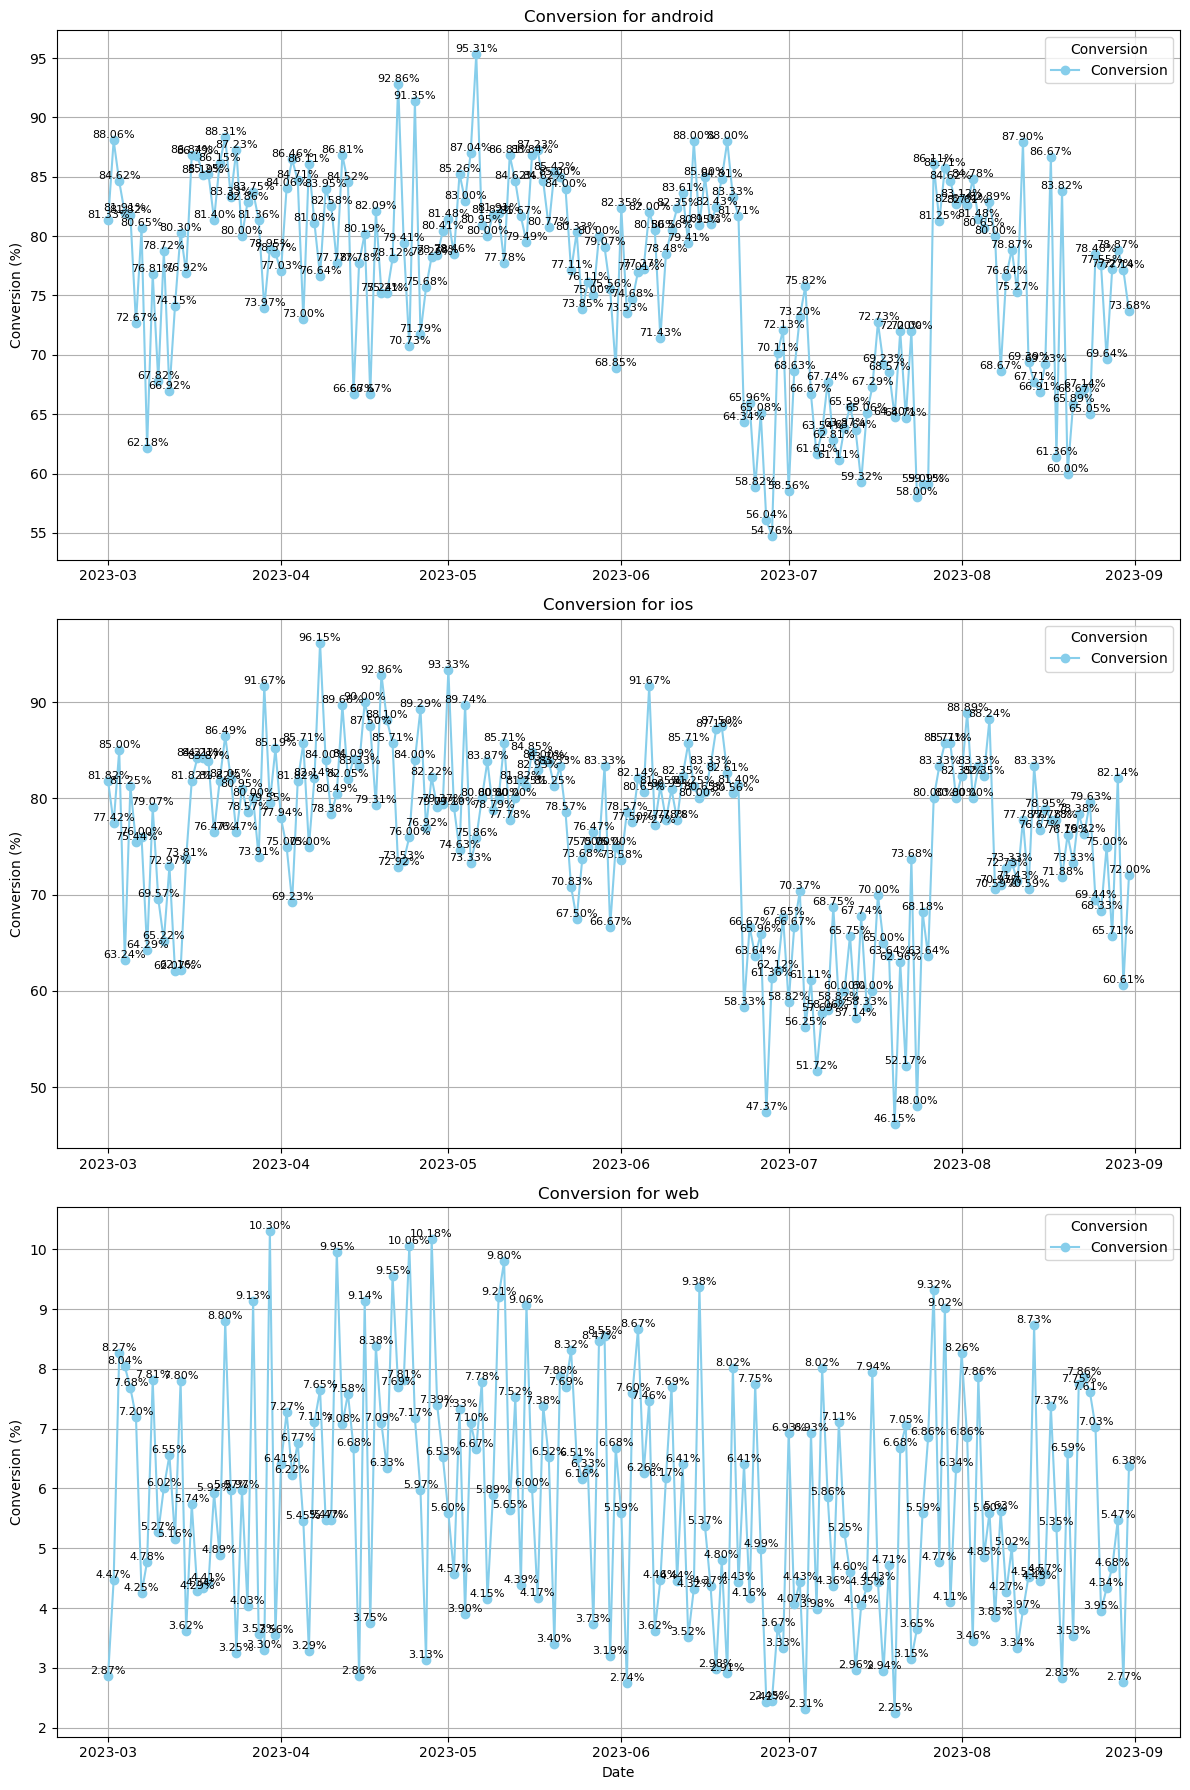

In [37]:
final_df['date_group'] = pd.to_datetime(final_df['date_group'])

# Создаем сводную таблицу для получения итоговых конверсий по дням для каждой платформы
conversion_data = final_df.groupby(['date_group', 'platform'])['conversion'].mean().reset_index()

platforms = conversion_data['platform'].unique()

# Настраиваем графики
fig, axs = plt.subplots(len(platforms), 1, figsize=(12, 18))

for i, platform in enumerate(platforms):
    platform_data = conversion_data[conversion_data['platform'] == platform]
    axs[i].plot(platform_data['date_group'], platform_data['conversion'], marker='o', color='skyblue', label='Conversion')

    # Добавляем подписанные значения на график
    for idx, row in platform_data.iterrows():
        axs[i].text(row['date_group'], row['conversion'], f"{row['conversion']:.2f}%", 
                    ha='center', va='bottom', fontsize=8)

    # Настроим заголовки и метки для каждого графика
    axs[i].set_title(f'Conversion for {platform}')
    axs[i].set_ylabel('Conversion (%)')
    axs[i].grid()
    axs[i].legend(title='Conversion')

# Настройка оси X
plt.xlabel('Date')

plt.tight_layout()
plt.show()

#Сохраняем график
#plt.savefig('./charts/6.conversion_by_web_andr_ios.png')

##### 5.7 Стоимости реклам

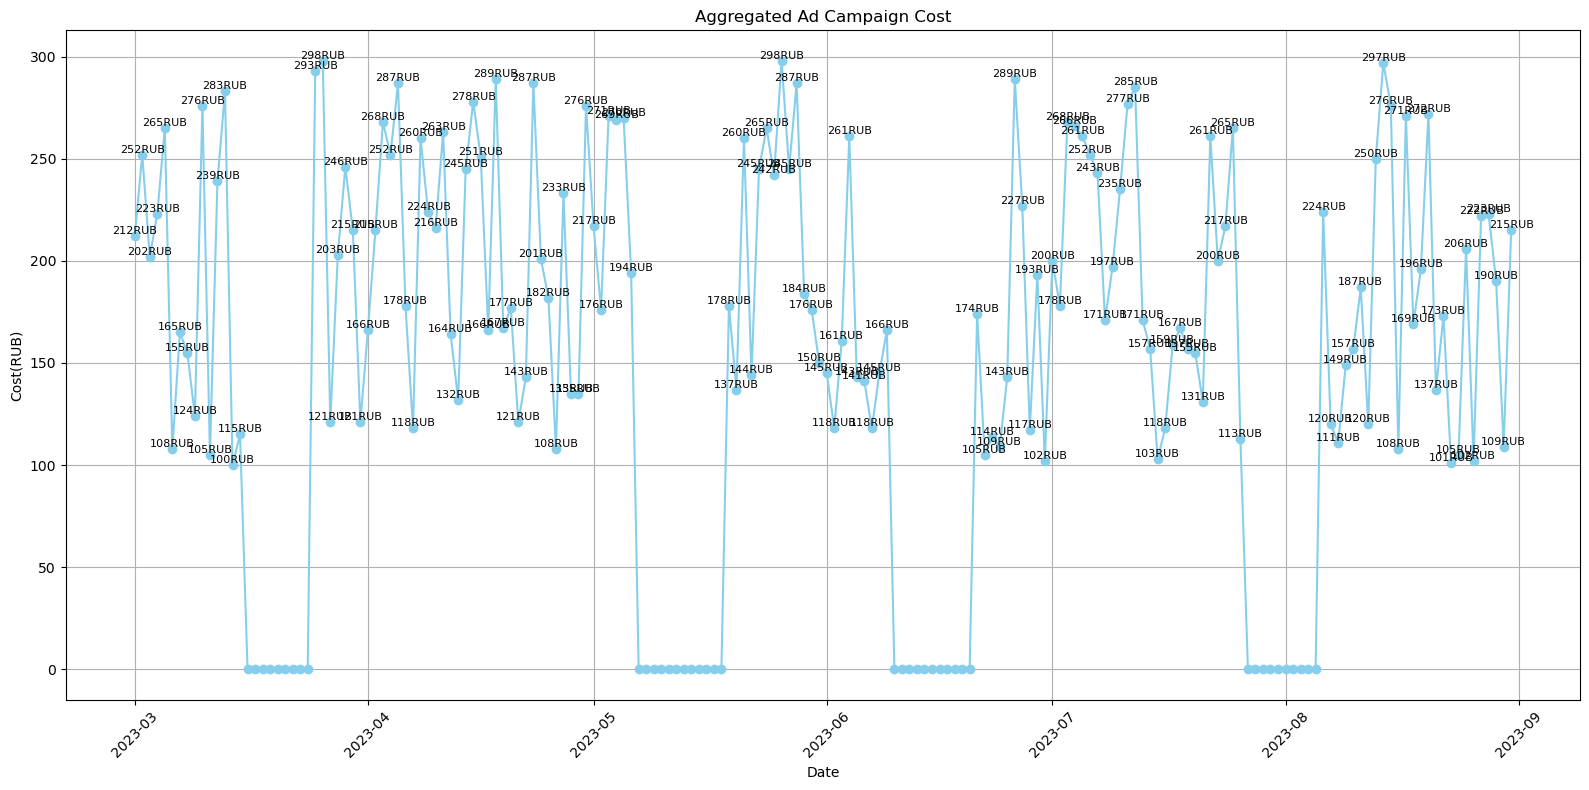

In [39]:
# Создаем final_result из ads_merged
final_result = ads_merged.copy()
final_result['date_group'] = pd.to_datetime(final_result['date_group'])

# Настройка графика
plt.figure(figsize=(16, 8))
plt.plot(final_result['date_group'], final_result['cost'], marker='o', linestyle='-', color='skyblue')

for idx, row in final_result.iterrows():
    if row['cost'] == 0:
            continue
    plt.text(row['date_group'], row['cost'], f"{row['cost']:.0f}RUB", 
             ha='center', va='bottom', fontsize=8)

# Добавление подписей и заголовка
plt.title('Aggregated Ad Campaign Cost')
plt.xlabel('Date')
plt.ylabel('Cost(RUB)')
plt.xticks(rotation=45)  # Поворот меток оси X для удобства чтения
plt.grid()
plt.tight_layout()

plt.show()

#Сохраняем график
#plt.savefig('./charts/7.ad_cost.png')

##### 5.8 Визиты за весь период с цветовым выделением рекламной кампании

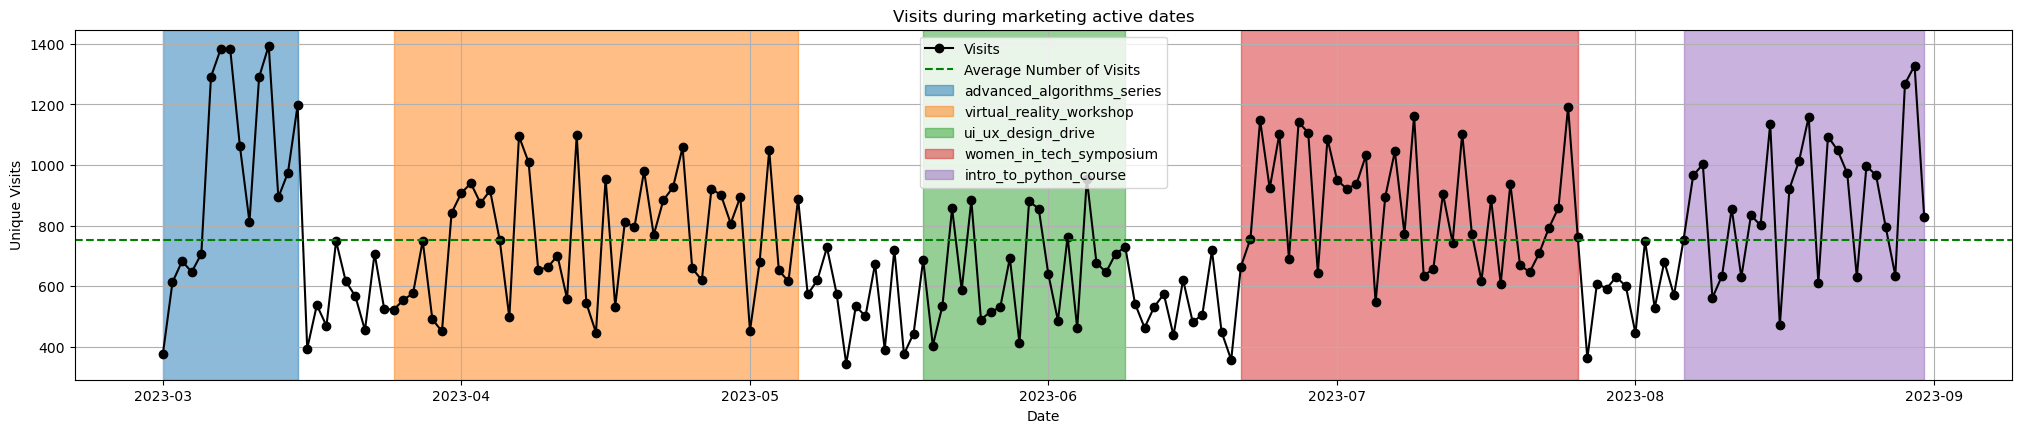

In [42]:
plt.figure(figsize = (25, 10))

campaign_colors = dict(zip(campaign_periods['utm_campaign'].unique(), plt.cm.tab10.colors[:len(campaign_periods['utm_campaign'].unique())]))
plt.subplot(2, 1, 1)

plt.plot(final_result['date_group'], final_result['visits'], marker='o', color='black', label='Visits')
plt.axhline(y=np.nanmean(final_result.visits), linestyle='dashed', color='green', label='Average Number of Visits')
for _,row in campaign_periods.iterrows():
    plt.axvspan(row['start'], row['finish'], label=row['utm_campaign'], color=campaign_colors[row['utm_campaign']], alpha=0.5)
plt.title('Visits during marketing active dates')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Unique Visits')
plt.grid(True)

plt.show()

#Сохраняем график
#plt.savefig('./charts/8.visits_during_campaigns.png')

##### 5.9 Регистрации за весь период с цветовым выделением рекламной кампании

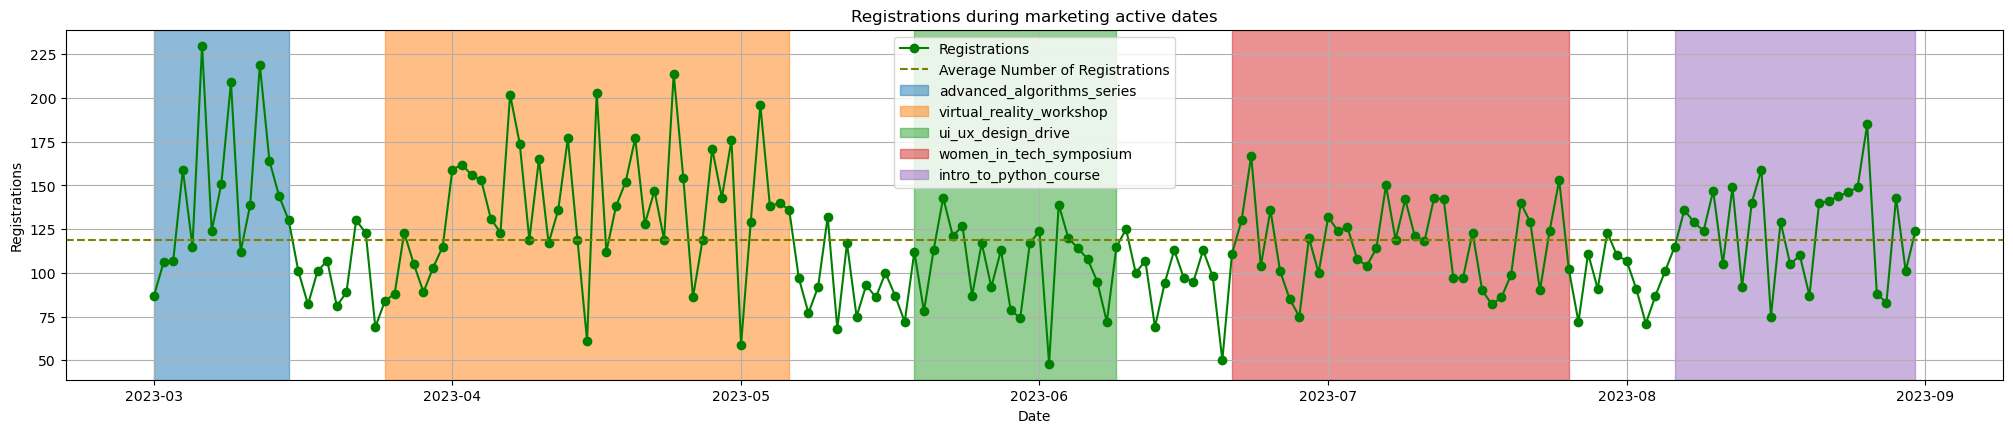

In [43]:
plt.figure(figsize=(25,10))

campaign_colors = dict(zip(campaign_periods['utm_campaign'].unique(), plt.cm.tab10.colors[:len(campaign_periods['utm_campaign'].unique())]))
plt.subplot(2, 1, 1)

plt.plot(final_result['date_group'], final_result['registrations'], marker='o', color='green', label='Registrations')
plt.axhline(y=np.nanmean(final_result.registrations), linestyle='dashed', color='olive', label='Average Number of Registrations')
for _,row in campaign_periods.iterrows():
    plt.axvspan(row['start'], row['finish'], label=row['utm_campaign'], color=campaign_colors[row['utm_campaign']], alpha=0.5)
plt.title('Registrations during marketing active dates')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Registrations')
plt.grid(True)

plt.show()

#Сохраняем график
#plt.savefig('./charts/ads_registrations.png')